# Streaming Transform

Stream fire area data from GOES-17 through NDP, graph number and location of pixels with greater than 75,000sqm fire area.

**Library Imports**

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, clear_output
from pydsvdc import DsVdc
import numpy as np

**Initialize Plot**

In [2]:
%matplotlib agg
fig, axs = plt.subplots(2,1)
line, = axs[0].plot([], [])
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[0].set_title('Major Fire Pixels Sep 2, 2020')
gridspec = axs[1].get_subplotspec().get_gridspec()
axs[1].remove()
subfig = fig.add_subfigure(gridspec[1])
subplt = subfig.subplots()
x_data = []
y_data = []

**Data Transform**

This function will be run in the DataSpaces server on matching data. The argument is the data (as a ndarray). Whatever is returned by the function will be included in subscription response. If the function returns None, no response will be generated for that matching data.

Define a function to be run on the DataSpaces server; takes the Area pixel map and returns a list of coordinates that meet the threshold.

In [ ]:
def sub_fn(a):
    import numpy as np
    x,y = np.where(a > 75000)
    return list(zip(x,y))

**Initialize Library**

Service can be found via parameters, environment variables, etc.

In [ ]:
dv = DsVdc()

**Get Figure Backdrop**

Download radiance data to draw a picture to backgroup the fire map. We choose September 9, 2020 because that's when our demo stream will be from. Convert radiance to gamma that looks nice. We subset to the bounds we do so that we can just draw the West Coast instead of the image being dominated by the Pacific Ocean.

In [5]:
lb = (0, 2500)
ub = (1499, 4999)
qres = dv.query(name = f'RadC/C3/Rad', time = '202009091800', lb=lb, ub=ub)
(tstamp, radiance) = qres[0] 

# Define some constants needed for the conversion. From the pdf linked above
Esun_Ch_01 = 726.721072
Esun_Ch_02 = 663.274497
Esun_Ch_03 = 441.868715
d2 = 0.3
# Apply the formula to convert radiance to reflectance
ref = (radiance * np.pi * d2) / Esun_Ch_02

# Make sure all data is in the valid data range
ref = np.maximum(ref, 0.0)
ref = np.minimum(ref, 1.0)

# Apply the formula to adjust reflectance gamma
ref_gamma = np.sqrt(ref)

**Plot Radiance**

In [6]:
im = subplt.imshow(ref_gamma, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = subfig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Reflectance')

**Create subscription**

Subscribe to the FDCC Area variable, with an subscription that is valid for any data streamed between the start of 2020 and mid 2023. Attach our `sub_fn` function to the stream, which in this case transforms the satellite imagery into a list of coordinates that meet our fire area threshold.

Print a subscription handle, which others can use to subscribe to the same results.

In [ ]:
subscription = dv.sub(name = f'FDCC/Area', start_time = '20200101', end_time = '20230630', xform = sub_fn)
print(f'subscription handle: {subscription.handle}')

**Iterate Subscription Results**

The subscription can be iterated to get results (one "timestep" per iteration). We make a new red mask, masking out a largish dot at each point in the listed results. We also add a data point to our line graph that is the length of the list of coordinates we get back, meaning the total number of pixels that meet the area threshold.

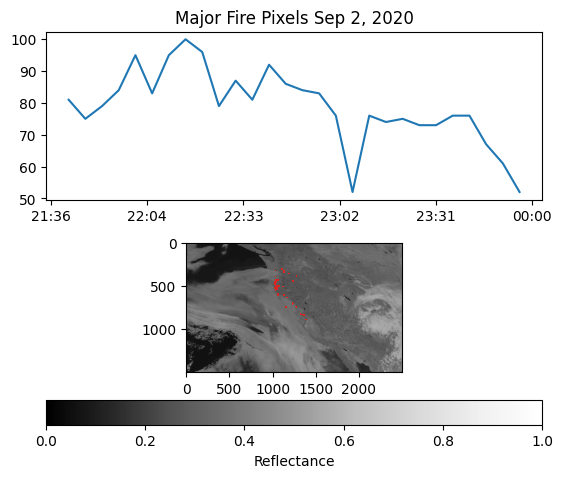

In [ ]:
for result in subscription:
    fire_spots = result["data"]
    fire_pixels = np.zeros(radiance.shape)
    for i,j in fire_spots:
        idx = (slice(i+230,i+270), slice(j-770,j-730))
        #print(idx)
        fire_pixels[idx] = .7
    fire_pixels = np.ma.masked_where(fire_pixels == 0,fire_pixels)
    area = len(fire_spots)
    x_data.append(result["tstamp"])
    y_data.append(area)
    line.set_data(x_data, y_data)
    axs[0].relim() 
    axs[0].autoscale_view(True,True,True)
    im2 = subplt.imshow(fire_pixels, vmin=0.0, vmax=1.0, cmap='Reds')
    clear_output(wait=True)
    display(fig)

In [ ]:
plt.close()